# NYC Taxi + Weather Analysis (PySpark) — Notebook Template

**Purpose:** Load NYC Yellow Taxi monthly CSVs (2019–2020) and hourly weather CSV, join them, answer 10 analytic questions, and export summaries for Tableau or modeling.

**Run environment:** Local Jupyter notebook with PySpark available.

**Notes:** 
- Update file paths in the next cell if needed. 
- If your CSV column names include spaces or special chars (e.g., `temperature_2m (°C)`), we rename them to safe snake_case names in the notebook.


In [3]:
## !pip install pyspark
## !pip install pandas
## !pip install plotly

In [1]:
# Section 1 — Setup & imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, date_trunc, hour, dayofweek, month, year, when, unix_timestamp,
    count, avg, corr, first
)
from pyspark.sql.types import TimestampType

# Create Spark session (adjust memory/config as needed)
spark = SparkSession.builder \
    .appName("NYC Taxi Weather Analysis") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

print("Spark session created:", spark)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/03 18:31:26 WARN Utils: Your hostname, Lilys-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.140 instead (on interface en0)
25/12/03 18:31:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/03 18:31:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session created: <pyspark.sql.session.SparkSession object at 0x130512120>


In [2]:
# Section 2 — File paths (UPDATE if different)
weather_path = "./Weather_Data/weather_2019_2020.csv"
taxi_glob_2019 = r"./Taxi_Data/yellow_tripdata_2019-*.csv"
taxi_glob_2020 = r"./Taxi_Data/yellow_tripdata_2020-*.csv"

print("Weather:", weather_path)
print("Taxi 2019 pattern:", taxi_glob_2019)
print("Taxi 2020 pattern:", taxi_glob_2020)


Weather: ./Weather_Data/weather_2019_2020.csv
Taxi 2019 pattern: ./Taxi_Data/yellow_tripdata_2019-*.csv
Taxi 2020 pattern: ./Taxi_Data/yellow_tripdata_2020-*.csv


In [3]:
# Section 3 — Load data into Spark DataFrames
weather_df = spark.read.option("header", True).option("inferSchema", True).csv(weather_path)

print("Weather schema:")
weather_df.printSchema()
weather_df.show(3, truncate=False)

taxi_df_2019 = spark.read.option("header", True).option("inferSchema", True).csv(taxi_glob_2019)
taxi_df_2020 = spark.read.option("header", True).option("inferSchema", True).csv(taxi_glob_2020)
taxi_df = taxi_df_2019.unionByName(taxi_df_2020)

print("Taxi schema:")
taxi_df.printSchema()
taxi_df.select('tpep_pickup_datetime','tpep_dropoff_datetime','PULocationID','DOLocationID','fare_amount').show(5, truncate=False)
print('Total taxi rows (approx):', taxi_df.count())


Weather schema:
root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- time_only: timestamp (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- temperature_2m (°C): double (nullable = true)
 |-- precipitation (mm): double (nullable = true)
 |-- rain (mm): double (nullable = true)
 |-- cloudcover (%): double (nullable = true)
 |-- cloudcover_low (%): double (nullable = true)
 |-- cloudcover_mid (%): double (nullable = true)
 |-- cloudcover_high (%): double (nullable = true)
 |-- windspeed_10m (km/h): double (nullable = true)
 |-- winddirection_10m (°): double (nullable = true)

+----+-----+---+-------------------+-------------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+
|year|month|day|time_only          |time               |temperature_2m (°C)|precipitation (mm)|rain (mm)|cloudcover (%

25/12/03 18:34:47 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: ./Taxi_Data/yellow_tripdata_2019-*.csv.
java.io.FileNotFoundException: File Taxi_Data/yellow_tripdata_2019-*.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(ResolveDataSource.scala:143)
	at org.apache.spark

Taxi schema:
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

+--------------------+---------------------+------------+------------+-----------+
|tpep_pickup_datetime|tpep_dropoff_datetime|PULocationID|DOLocationID|f

Total taxi rows (approx): 101246797


In [7]:
# Section 4 — Normalize/rename weather columns to safe names (no spaces/special chars)
# Update these renames if your CSV uses slightly different headers.
rename_map = {
    'time': 'weather_time',
    'temperature_2m (°C)': 'temperature_c',
    'precipitation (mm)': 'precip_mm',
    'rain (mm)': 'rain_mm',
    'cloudcover (%)': 'cloudcover',
    'cloudcover_low (%)': 'cloudcover_low',
    'cloudcover_mid (%)': 'cloudcover_mid',
    'cloudcover_high (%)': 'cloudcover_high',
    'windspeed_10m (km/h)': 'windspeed_kmh',
    'winddirection_10m': 'winddir'
}

for old, new in rename_map.items():
    if old in weather_df.columns:
        weather_df = weather_df.withColumnRenamed(old, new)

# Cast weather_time to timestamp
weather_df = weather_df.withColumn('weather_time', col('weather_time').cast(TimestampType()))

print("Renamed weather cols:")
print(weather_df.columns)


Renamed weather cols:
['year', 'month', 'day', 'time_only', 'weather_time', 'temperature_c', 'precip_mm', 'rain_mm', 'cloudcover', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_kmh', 'winddirection_10m (°)']


In [8]:
# Section 5 — Prepare taxi timestamps and create pickup_hour
taxi_df = taxi_df.withColumn("tpep_pickup_datetime", col("tpep_pickup_datetime").cast(TimestampType())) \
                 .withColumn("tpep_dropoff_datetime", col("tpep_dropoff_datetime").cast(TimestampType()))

# Create pickup_hour (rounded/truncated to hour)
taxi_df = taxi_df.withColumn("pickup_hour", date_trunc("hour", col("tpep_pickup_datetime")))

# Quick check
taxi_df.select('tpep_pickup_datetime','pickup_hour').show(5, truncate=False)


+--------------------+-------------------+
|tpep_pickup_datetime|pickup_hour        |
+--------------------+-------------------+
|2019-01-01 00:46:40 |2019-01-01 00:00:00|
|2019-01-01 00:59:47 |2019-01-01 00:00:00|
|2018-12-21 13:48:30 |2018-12-21 13:00:00|
|2018-11-28 15:52:25 |2018-11-28 15:00:00|
|2018-11-28 15:56:57 |2018-11-28 15:00:00|
+--------------------+-------------------+
only showing top 5 rows


In [9]:
# Section 6 — Join taxi with weather (left join to keep all taxi records)
combined_df = taxi_df.join(weather_df, taxi_df.pickup_hour == weather_df.weather_time, how='left') \
                     .drop('weather_time')

print("Combined schema:")
combined_df.printSchema()

combined_df.select('pickup_hour','PULocationID','DOLocationID','fare_amount','temperature_c','rain_mm').show(5, truncate=False)


Combined schema:
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- pickup_hour: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = 

In [10]:
# Section 7 — Feature engineering
combined_df = combined_df.withColumn('hour', hour(col('pickup_hour'))) \
    .withColumn('day_of_week', dayofweek(col('pickup_hour'))) \
    .withColumn('month', month(col('pickup_hour'))) \
    .withColumn('year', year(col('pickup_hour'))) \
    .withColumn('is_rainy', when(col('rain_mm') > 0, 1).otherwise(0)) \
    .withColumn('is_cold', when(col('temperature_c') < 5, 1).otherwise(0))

# Trip duration in minutes
combined_df = combined_df.withColumn('duration_min', (unix_timestamp(col('tpep_dropoff_datetime')) - unix_timestamp(col('tpep_pickup_datetime'))) / 60)
combined_df.select('pickup_hour','hour','day_of_week','PULocationID','is_rainy','is_cold','duration_min').show(5, truncate=False)


+-------------------+----+-----------+------------+--------+-------+------------------+
|pickup_hour        |hour|day_of_week|PULocationID|is_rainy|is_cold|duration_min      |
+-------------------+----+-----------+------------+--------+-------+------------------+
|2019-01-01 00:00:00|0   |3          |151         |1       |0      |6.666666666666667 |
|2019-01-01 00:00:00|0   |3          |239         |1       |0      |19.2              |
|2018-12-21 13:00:00|13  |6          |236         |0       |0      |4.166666666666667 |
|2018-11-28 15:00:00|15  |4          |193         |0       |0      |3.3333333333333335|
|2018-11-28 15:00:00|15  |4          |193         |0       |0      |1.6               |
+-------------------+----+-----------+------------+--------+-------+------------------+
only showing top 5 rows


In [12]:
# Section 8 — Aggregations: hourly overall and hourly by zone

# City-wide hourly demand
city_hourly = combined_df.groupBy('pickup_hour','hour') \
    .agg(count('*').alias('trip_count'), avg('fare_amount').alias('avg_fare')) \
    .orderBy('pickup_hour')

city_hourly.show(5)

# Hourly demand by pickup zone
zone_hourly = combined_df.groupBy('pickup_hour','hour','PULocationID') \
    .agg(
        count('*').alias('trip_count'), 
        avg('fare_amount').alias('avg_fare'), 
        avg('duration_min').alias('avg_duration'), 
        avg('temperature_c').alias('avg_temp'), 
        avg('rain_mm').alias('avg_rain')
    ).orderBy('pickup_hour','PULocationID')

zone_hourly.show(5)


+-------------------+----+----------+------------------+
|        pickup_hour|hour|trip_count|          avg_fare|
+-------------------+----+----------+------------------+
|2001-01-01 00:00:00|   0|         2|               8.5|
|2001-02-02 14:00:00|  14|         1|               2.5|
|2002-02-02 01:00:00|   1|        11|13.954545454545455|
|2002-12-31 22:00:00|  22|         1|               0.0|
|2002-12-31 23:00:00|  23|         1|               3.0|
+-------------------+----+----------+------------------+
only showing top 5 rows


ERROR:root:KeyboardInterrupt while sending command.                (0 + 8) / 72]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt


KeyboardInterrupt: 

## Question 1: How Does Hourly Taxi Demand Vary Throughout the Day? ##

In [ ]:
# Q1: How does hourly taxi demand vary throughout the day?
demand_by_hour = city_hourly.groupBy('hour').agg(avg('trip_count').alias('avg_trips')).orderBy('hour')
demand_by_hour.show(24)

# Export
demand_by_hour.coalesce(1).write.mode('overwrite').csv('outputs/demand_by_hour.csv', header=True)


+----+------------------+
|hour|         avg_trips|
+----+------------------+
|   0| 5275.260791366906|
|   1|3700.6666666666665|
|   2| 2600.190476190476|
|   3|1863.6003649635036|
|   4|1433.6386861313867|
|   5|1692.2531876138432|
|   6|3846.6854545454544|
|   7| 6764.540983606557|
|   8| 8462.445454545454|
|   9| 8613.586520947176|
|  10| 8651.165154264972|
|  11| 9092.161818181818|
|  12| 9647.972826086956|
|  13| 9787.379310344828|
|  14| 10319.35390199637|
|  15| 10372.43761301989|
|  16| 9820.644283121597|
|  17|11061.562613430127|
|  18| 12122.48731884058|
|  19|11411.127504553733|
|  20|10282.623188405798|
|  21|10133.723327305606|
|  22|  9419.59891107078|
|  23| 7380.220614828209|
+----+------------------+



In [ ]:
import plotly.express as px

df_hourly = demand_by_hour.toPandas()

fig = px.line(
    df_hourly,
    x="hour",
    y="avg_trips",
    title="Average NYC Taxi Demand by Hour of Day",
    markers=True,
    labels={"hour": "Hour of Day (0–23)", "avg_trips": "Avg Trips per Hour"},
    template="plotly_white"
)

fig.update_layout(
    xaxis=dict(dtick=1),
    title_font_size=20,
    yaxis_title="Avg Trips",
    xaxis_title="Hour"
)

fig.show()


## Question 2: Which NYC zones have the highest pickup activity? ##

In [ ]:
# Q2: Which NYC zones have the highest pickup activity?
zone_totals = combined_df.groupBy('PULocationID').agg(count('*').alias('total_trips')).orderBy(col('total_trips').desc())
zone_totals.show(20)

zone_totals.coalesce(1).write.mode('overwrite').csv('outputs/zone_totals.csv', header=True)


+------------+-----------+
|PULocationID|total_trips|
+------------+-----------+
|         237|    4381819|
|         161|    4150064|
|         236|    3993845|
|         162|    3646602|
|         186|    3616284|
|         230|    3465283|
|         132|    3237159|
|          48|    3192020|
|         170|    3112745|
|         142|    3035796|
|         234|    3022014|
|         163|    2704450|
|         239|    2640544|
|          79|    2558840|
|         138|    2479920|
|          68|    2431547|
|         141|    2386134|
|         164|    2325227|
|         107|    2276794|
|         100|    2051024|
+------------+-----------+
only showing top 20 rows


### Analysis ###


The results show that the highest taxi pickup activity is heavily concentrated in Manhattan, particularly in the Upper East Side and Midtown regions. The busiest zones include Upper East Side North (PULocationID 237), Midtown Center (161), and Upper East Side South (236), each recording around four million or more total pickups. Other major hotspots such as Midtown North, Murray Hill–Kips Bay, Times Square, and several Upper West Side zones also rank within the top 20. These areas are characterized by dense residential neighborhoods, major business districts, high tourism, and large transit hubs, all of which contribute to consistently strong taxi demand. Overall, the results highlight that Manhattan dominates taxi pickup activity across the city.

### Analysis ###


## Question 3: How does rain affect taxi demand / number of pickups ? ##

How many trips occured when it was raining vs when it was not raining, and how was the average fare different ? 

In [ ]:

rain_stats = combined_df.groupBy('is_rainy').agg(count('*').alias('trip_count'), avg('fare_amount').alias('avg_fare'))
rain_stats.show()

# Save
rain_stats.coalesce(1).write.mode('overwrite').csv('outputs/rain_stats.csv', header=True)


+--------+----------+-----------------+
|is_rainy|trip_count|         avg_fare|
+--------+----------+-----------------+
|       1|  13364148|13.21535354517182|
|       0|  87901683| 13.2444002481721|
+--------+----------+-----------------+



Total trip count during rainy hours was significantly lower than non-rain hours, however this does not clearly suggest any pattern as the ratio of rainy versus non-rainy hours in the dataset was not factored in. 

Does rain increase or decrease taxi demand on a per-hour basis? (Did raining hours have more pickups than non-rain hours?)

In [ ]:
#2 groups: 0 precipitation and >0 precipitation 
from pyspark.sql import functions as F

hourly_counts = (
    combined_df
    .groupBy("pickup_hour", "hour", "is_rainy")
    .agg(F.count("*").alias("trip_count"))
)
avg_by_rain = (
    hourly_counts
    .groupBy("is_rainy")
    .agg(F.avg("trip_count").alias("avg_trips_per_hour"))
    .orderBy("is_rainy")  
)
avg_by_rain.show()

+--------+------------------+
|is_rainy|avg_trips_per_hour|
+--------+------------------+
|       0| 7694.475052521008|
|       1| 7453.512548800893|
+--------+------------------+



In [ ]:
#4 groups based on precipitation amt 
combined_df_prec_levels = (
    combined_df
    .withColumn(
        "precip_level",
        F.when(F.col("rain_mm") == 0, "None")
         .when((F.col("rain_mm") > 0) & (F.col("rain_mm") <= 1), "Light")
         .when((F.col("rain_mm") > 1) & (F.col("rain_mm") <= 5), "Moderate")
         .otherwise("Heavy")
    )
)
hourly_counts_prec_levels = (
    combined_df_prec_levels
    .groupBy("pickup_hour", "hour", "precip_level")
    .agg(F.count("*").alias("trip_count"))
)
avg_by_precip = (
    hourly_counts_prec_levels
    .groupBy("precip_level")
    .agg(F.avg("trip_count").alias("avg_trips_per_hour"))
    .orderBy("precip_level")
)

avg_by_precip.show()


+------------+------------------+
|precip_level|avg_trips_per_hour|
+------------+------------------+
|       Heavy|           1962.98|
|       Light|     7394.17421875|
|    Moderate| 7606.591375770021|
|        None| 7744.544493392071|
+------------+------------------+



The average trips (pickups) per hour was about 3.23% higher for hours when it was not raining compared to hours when it was raining outside. The difference is not hugely significant, so it is difficult to make a conclusion based on this analysis alone. This analysis did not factor into account the distribution of rainy hours versus non-rainy hours in the dataset over hours of the day, so it is also possible that the typical peaks and off-peaks could add noise to this calculation. 

Does rain change the distribution of demand across time?

In [ ]:
hourly_distribution = (
    hourly_counts
    .groupBy("hour", "is_rainy")
    .agg(F.avg("trip_count").alias("avg_trips"))
    .orderBy("hour", "is_rainy")
)

hourly_pivot = (
    hourly_distribution
    .groupBy("hour")
    .pivot("is_rainy", [0, 1])
    .agg(F.first("avg_trips"))
    .withColumnRenamed("0", "avg_trips_clear")
    .withColumnRenamed("1", "avg_trips_rain")
    .orderBy("hour")
)
hourly_pivot.show(24)


+----+------------------+------------------+
|hour|   avg_trips_clear|    avg_trips_rain|
+----+------------------+------------------+
|   0| 5303.867219917012|5088.9324324324325|
|   1|3688.8402489626556|            3782.1|
|   2|2608.5379746835442|2545.2361111111113|
|   3| 1880.162886597938| 1736.095238095238|
|   4|1442.9248434237995|1369.1739130434783|
|   5|1694.1945031712473| 1680.171052631579|
|   6|3834.1365546218485|3927.4054054054054|
|   7| 6736.797872340426| 6929.594936708861|
|   8| 8567.191176470587| 7788.675675675676|
|   9|  8727.73206751055|7892.1866666666665|
|  10|  8685.09631147541| 8388.333333333334|
|  11|  9057.90368852459| 9361.806451612903|
|  12|  9583.44578313253|10243.055555555555|
|  13| 9778.281690140846| 9871.111111111111|
|  14|10351.713402061856|10081.560606060606|
|  15| 10422.42468619247|10053.853333333333|
|  16| 9890.517671517671| 9340.514285714286|
|  17|11196.117270788913|10291.975609756097|
|  18|12284.768085106383|11192.341463414634|
|  19|1154

+------------+------------------+
|precip_level|avg_trips_per_hour|
+------------+------------------+
|       Heavy|           1962.98|
|       Light|     7394.17421875|
|    Moderate| 7606.591375770021|
|        None| 7744.544493392071|
+------------+------------------+



In [ ]:
##Plot results:

import pandas
import plotly.express as px
hourly_pd = hourly_pivot.toPandas()
fig = px.line(
    hourly_pd,
    x="hour",
    y=["avg_trips_clear", "avg_trips_rain"],
    title="Hourly Taxi Demand: Rain vs Clear",
    labels={"value": "Average Trips", "variable": "Weather"},
    markers=True,
    template="plotly_dark"
)
fig.update_layout(
    xaxis=dict(dtick=1),
    legend_title_text="Condition"
)
fig.show()

In [ ]:
## 4 groups 
import plotly.express as px

hourly_distribution_prec_levels = (
    hourly_counts_prec_levels
    .groupBy("hour", "precip_level")
    .agg(F.avg("trip_count").alias("avg_trips"))
    .orderBy("hour", "precip_level")
)
hourly_pivot_prec_levels = (
    hourly_distribution_prec_levels
    .groupBy("hour")
    .pivot("precip_level", ["None", "Light", "Moderate", "Heavy"])
    .agg(F.first("avg_trips"))
    .orderBy("hour")
)
hourly_pivot_prec_levels.show(24)

prec_levels_pd = hourly_pivot_prec_levels.toPandas()
prec_levels_pd = prec_levels_pd.rename(columns={
    "None": "No Rain",
    "Light": "Light Rain",
    "Moderate": "Moderate Rain",
    "Heavy": "Heavy Rain"
})
fig = px.line(
    prec_levels_pd,
    x="hour",
    y=["No Rain", "Light Rain", "Moderate Rain", "Heavy Rain"],
    title="Hourly Taxi Demand by Precipitation Level",
    labels={"value": "Average Trips", "variable": "Precipitation"},
    markers=True,
    template="plotly_dark"
)

fig.update_layout(xaxis=dict(dtick=1))
fig.show()

+----+------------------+------------------+------------------+------------------+
|hour|              None|             Light|          Moderate|             Heavy|
+----+------------------+------------------+------------------+------------------+
|   0| 5370.100840336135| 4468.411764705882| 6526.318181818182| 772.7142857142857|
|   1| 3727.356394129979|3554.7083333333335| 4340.428571428572| 507.3333333333333|
|   2|2613.9936575052852| 2303.769230769231| 3337.842105263158|              35.0|
|   3|1884.0330578512396|1609.5555555555557|2052.4444444444443|               7.0|
|   4|1445.9225941422594|1302.3958333333333| 1317.157894736842|            2314.0|
|   5|1697.7796610169491|1625.1607142857142|1840.8333333333333|1183.6666666666667|
|   6|3858.4418604651164|3981.2156862745096| 3808.086956521739|               2.0|
|   7| 6751.157782515991|           6794.15| 7357.315789473684|               2.0|
|   8| 8585.214736842105| 7907.018518518518|           7469.15|               6.0|
|   

These results show that heavy rain seems to greatly decrease taxi demand overall, and that clear weather, especially during peak hours, tends to have the highest demand compared to any amount of precipitation greater than 0. It appears that light and moderate precipitation do not affect the distribution of demand throughout the day, and thqt the peak and off-peak hours stay the same under these conditions. When there is light or moderate precipitaiton, the demand may be slightly higher in off-peak hours compared to when there is no rain. 

## Question 4: Do colder temperatures lead to higher taxi usage? ##

In [ ]:
# Q4: Do colder temperatures lead to higher taxi usage?
cold_stats = combined_df.groupBy('is_cold').agg(count('*').alias('trip_count'), avg('fare_amount').alias('avg_fare'))
cold_stats.show()

cold_stats.coalesce(1).write.mode('overwrite').csv('outputs/cold_stats.csv', header=True)


+-------+----------+------------------+
|is_cold|trip_count|          avg_fare|
+-------+----------+------------------+
|      1|  33175793|12.834127621304953|
|      0|  68090038|13.438598044107012|
+-------+----------+------------------+



In [ ]:
from pyspark.sql import functions as F

combined_df_temp = (
    combined_df
    .withColumn(
        "temp_level",
        F.when(F.col("temperature_c") < 0, "Very Cold")
         .when(F.col("temperature_c") < 5, "Cold")
         .when(F.col("temperature_c") < 15, "Cool")
         .otherwise("Warm")
    )
)

hourly_counts_temp = (
    combined_df_temp
    .groupBy("pickup_hour", "hour", "temp_level")
    .agg(F.count("*").alias("trip_count"))
)

avg_by_temp = (
    hourly_counts_temp
    .groupBy("temp_level")
    .agg(F.avg("trip_count").alias("avg_trips_per_hour"))
    .orderBy("avg_trips_per_hour", ascending=False)
)
avg_by_temp.show()
hourly_distribution_temp = (
    hourly_counts_temp
    .groupBy("hour", "temp_level")
    .agg(F.avg("trip_count").alias("avg_trips"))
    .orderBy("hour", "temp_level")
)
hourly_distribution_temp_pivot = (
    hourly_distribution_temp
    .groupBy("hour")
    .pivot("temp_level", ["Very Cold", "Cold", "Cool", "Warm"])
    .avg("avg_trips")
    .orderBy("hour")
)
hourly_distribution_temp_pivot.show()

+----------+------------------+
|temp_level|avg_trips_per_hour|
+----------+------------------+
| Very Cold| 9802.563636363637|
|      Cold| 8810.665818490246|
|      Warm| 7206.363498098859|
|      Cool| 6964.597600369174|
+----------+------------------+



+----+------------------+------------------+------------------+------------------+
|hour|         Very Cold|              Cold|              Cool|              Warm|
+----+------------------+------------------+------------------+------------------+
|   0|7398.2307692307695| 6432.765957446809| 4614.114130434783| 4982.581589958159|
|   1| 4924.954545454545| 4481.292929292929|3126.9840425531916| 3595.244343891403|
|   2|         3452.6875|2939.9791666666665| 2266.427807486631|2548.4418604651164|
|   3| 2389.698113207547| 2378.233644859813|1542.9304812834225|1749.2537313432836|
|   4|1892.3275862068965|1657.1214953271028|1225.6702702702703|1372.8181818181818|
|   5| 2078.064516129032|1931.1607142857142|1460.8833333333334|1645.9384615384615|
|   6| 4836.184615384615| 4324.017094017094| 3350.637931034483| 3672.185567010309|
|   7|  8703.89705882353| 7617.387931034483| 6147.005681818182| 6118.402116402116|
|   8|           11051.6| 9614.196581196582| 7457.897727272727| 7718.085561497326|
|   

In [ ]:
import plotly.express as px

hourly_temp_pd = hourly_distribution_temp.toPandas()

fig = px.line(
    hourly_temp_pd,
    x="hour",
    y="avg_trips",
    color="temp_level",
    title="Taxi Demand by Hour Under Different Temperature Levels",
    markers=True,
    template="plotly_dark"
)
fig.update_layout(
    xaxis=dict(dtick=1),
    legend_title_text="Temperature Level"
)
fig.show()


Here we can very clearly see that temperature has a direct impact on taxi demand. Very cold temperatures have the highest taxi demand at all hours of the day, and contribute to an even larger peak during the typical overall peak hours. Cold temperatures have a similar but lesser effect, and cool temperatures hover close to warm temperatures or slightly higher. 

## Question 5: Are trip durations longer during bad weather? ##

In [ ]:
duration_by_rain = combined_df.groupBy('is_rainy').agg(avg('duration_min').alias('avg_duration_min'))
duration_by_rain.show()

duration_by_rain.coalesce(1).write.mode('overwrite').csv('outputs/duration_by_rain.csv', header=True)


+--------+------------------+
|is_rainy|  avg_duration_min|
+--------+------------------+
|       1|17.580494497915883|
|       0|17.656157266067805|
+--------+------------------+



In [ ]:
duration_df_1 = combined_df.withColumn(
    "duration_min",
    (F.unix_timestamp("tpep_dropoff_datetime") -
     F.unix_timestamp("tpep_pickup_datetime")) / 60
)
avg_duration_1 = (
    duration_df_1
    .groupBy("is_rainy")
    .agg(F.avg("duration_min").alias("avg_duration_min"))
)

avg_duration_1.show()

+--------+------------------+
|is_rainy|  avg_duration_min|
+--------+------------------+
|       1|17.580494497915883|
|       0|17.656157266067805|
+--------+------------------+



In [ ]:
duration_precip = combined_df.withColumn(
    "precip_level",
    F.when(F.col("precip_mm") == 0, "0. None")
     .when(F.col("precip_mm") < 1, "1. Light (<1mm)")
     .when(F.col("precip_mm") < 3, "2. Moderate (1–3mm)")
     .otherwise("3. Heavy (>3mm)")
)
avg_duration_precip = (
    duration_precip
    .groupBy("precip_level")
    .agg(F.avg("duration_min").alias("avg_duration_min"))
    .orderBy("precip_level")
)

avg_duration_precip.show()

duration_quantiles = (
    duration_precip
    .groupBy("precip_level")
    .agg(F.expr("percentile(duration_min, 0.5)").alias("median_duration"),
         F.expr("percentile(duration_min, 0.9)").alias("p90_duration"))
)
pd_precip = avg_duration_precip.toPandas()

import plotly.express as px
fig = px.bar(
    pd_precip,
    x="precip_level",
    y="avg_duration_min",
    title="Average Trip Duration by Precipitation Level",
    text_auto=".2f",
    template="plotly_dark"
)
fig.show()


+-------------------+------------------+
|       precip_level|  avg_duration_min|
+-------------------+------------------+
|            0. None| 17.66349133153426|
|    1. Light (<1mm)|17.676529455092957|
|2. Moderate (1–3mm)|17.111681629551196|
|    3. Heavy (>3mm)|17.930004926887953|
+-------------------+------------------+



In [ ]:
duration_temp = combined_df.withColumn(
    "temp_level",
    F.when(F.col("temperature_c") < 5, "Cold (<5°C)")
    .when(F.col("temperature_c") > 25, "Hot (>25°C)")
    .otherwise("Mild (5–25°C)")
)

avg_duration_temp = (
    duration_temp
    .groupBy("temp_level")
    .agg(F.avg("duration_min").alias("avg_duration_min"))
    .orderBy("temp_level")
)

avg_duration_temp.show()

temp_stats = (
    duration_temp
    .groupBy("temp_level")
    .agg(
        F.avg("duration_min").alias("avg_duration"),
        F.expr("percentile(duration_min, 0.5)").alias("median_duration")
    )
    .orderBy("temp_level")
)

pd_temp = temp_stats.toPandas()

fig = px.bar(
    pd_temp,
    x="temp_level",
    y=["avg_duration", "median_duration"],
    barmode="group",
    title="Trip Duration vs Temperature Category",
    labels={"value": "Duration (minutes)", "temp_level": "Temperature Level"},
    text_auto=".1f",
    template="plotly_dark"
)
fig.show()



ConnectionRefusedError: [Errno 61] Connection refused

## Question 6: Which zones experience the highest fare surges?  ##

In [ ]:
# Q6: Which zones experience the highest fare surges?
from pyspark.sql.functions import first

zone_fare_weather = combined_df.groupBy('PULocationID','is_rainy').agg(avg('fare_amount').alias('avg_fare'))
zone_fare_pivot = zone_fare_weather.groupBy('PULocationID').pivot('is_rainy', [0,1]).agg(first('avg_fare'))
# rename pivot columns if they exist
cols = zone_fare_pivot.columns
if '0' in cols:
    zone_fare_pivot = zone_fare_pivot.withColumnRenamed('0','fare_clear')
if '1' in cols:
    zone_fare_pivot = zone_fare_pivot.withColumnRenamed('1','fare_rainy')

zone_fare_pivot = zone_fare_pivot.withColumn('pct_increase', (col('fare_rainy') - col('fare_clear'))/col('fare_clear')*100)
zone_fare_pivot.orderBy(col('pct_increase').desc()).show(20)

zone_fare_pivot.coalesce(1).write.mode('overwrite').csv('outputs/zone_fare_pivot.csv', header=True)


+------------+------------------+------------------+------------------+
|PULocationID|        fare_clear|        fare_rainy|      pct_increase|
+------------+------------------+------------------+------------------+
|          99| 50.70421052631579| 81.53999999999999|60.815047021943556|
|         204| 76.35790697674419|108.35666666666667|  41.9062818205168|
|         105| 15.47518181818182|             21.75| 40.54762170513489|
|           6| 25.04774436090225| 34.62963636363637| 38.25451052467134|
|          31|26.143431855500825|33.836883116883115|29.427855164177746|
|          84| 66.10478260869564|            84.086|27.201083918153667|
|         109| 46.70863636363637| 58.17777777777778| 24.55464836278193|
|         252|32.536597724922444| 39.49647260273972|21.390911664024845|
|         160| 26.30846153846154| 31.77142091152815|20.765027879262572|
|         128|25.147288732394358| 29.92939655172414|19.016395247291776|
|          96| 32.62893457943927| 38.52765306122448|18.078182931

Question 7: What is the correlation between precipitation and city-wide taxi demand? 

In [ ]:
# Q7: Correlation between precipitation and demand (city-wide)
# First ensure weather's rain is joined to city_hourly
hourly_weather = weather_df.select(col('weather_time').alias('pickup_hour'), col('rain_mm'))
hourly_weather_demand = city_hourly.join(hourly_weather, on='pickup_hour', how='left').select('pickup_hour','trip_count', 'rain_mm')
hourly_weather_demand.select(corr('rain_mm', 'trip_count').alias('corr_rain_trip')).show()

hourly_weather_demand.coalesce(1).write.mode('overwrite').csv('outputs/hourly_weather_demand.csv', header=True)


+--------------------+
|      corr_rain_trip|
+--------------------+
|-0.00350017754726...|
+--------------------+



Question 8: What are the best predictors of hourly taxi demand ? 

In [ ]:
# Q8: Best predictors of hourly taxi demand using RandomForest feature importance
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Prepare hourly weather averaged features
hourly_weather_avg = weather_df.groupBy('weather_time') \
    .agg(avg('temperature_c').alias('avg_temp'), avg('rain_mm').alias('avg_rain'), avg('windspeed_kmh').alias('avg_wind')) \
    .withColumnRenamed('weather_time', 'pickup_hour')

ml_df = city_hourly.join(hourly_weather_avg, on='pickup_hour', how='left').na.fill(0)
ml_df = ml_df.withColumn('hour', hour(col('pickup_hour'))).withColumn('day_of_week', dayofweek(col('pickup_hour')))

assembler = VectorAssembler(inputCols=['hour','day_of_week','avg_temp','avg_rain','avg_wind'], outputCol='features')
rf = RandomForestRegressor(featuresCol='features', labelCol='trip_count', numTrees=50)
pipeline = Pipeline(stages=[assembler, rf])

train_df, test_df = ml_df.randomSplit([0.8,0.2], seed=42)
model = pipeline.fit(train_df)
preds = model.transform(test_df)

evaluator = RegressionEvaluator(labelCol='trip_count', predictionCol='prediction', metricName='rmse')
print('RMSE:', evaluator.evaluate(preds))

rf_model = model.stages[-1]
print('Feature importances:', rf_model.featureImportances)


RMSE: 4361.573998080268
Feature importances: (5,[0,1,2,3,4],[0.8216500966483011,0.06108778558912552,0.09273026574708107,0.005669511980049037,0.01886234003544334])


In [ ]:
# Q9: Forecast next-day demand using lag features + RandomForest
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

city_hourly = city_hourly.orderBy('pickup_hour')
w = Window.orderBy('pickup_hour')

lagged = city_hourly.withColumn('lag_1', lag('trip_count',1).over(w)).withColumn('lag_24', lag('trip_count',24).over(w)).na.fill(0)
lagged = lagged.withColumn('hour', hour(col('pickup_hour'))).withColumn('day_of_week', dayofweek(col('pickup_hour')))

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

assembler = VectorAssembler(inputCols=['lag_1','lag_24','hour','day_of_week'], outputCol='features')
ml_lag = assembler.transform(lagged).select('features','trip_count')

train, test = ml_lag.randomSplit([0.8,0.2], seed=42)
rf2 = RandomForestRegressor(featuresCol='features', labelCol='trip_count', numTrees=50)
model2 = rf2.fit(train)
preds2 = model2.transform(test)
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol='trip_count', predictionCol='prediction', metricName='rmse')
print('Forecast RMSE:', evaluator.evaluate(preds2))


25/12/03 15:08:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 15:08:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 15:08:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 15:08:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 15:08:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 15:09:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/03 1

Forecast RMSE: 999.041456083051


In [ ]:
# Q10: Recommendations — compute zones with largest uplift and export
zone_hours = combined_df.groupBy('PULocationID','is_rainy').agg(count('*').alias('trips'))
zone_pivot = zone_hours.groupBy('PULocationID').pivot('is_rainy', [0,1]).agg(first('trips'))
# rename pivot cols if present
if '0' in zone_pivot.columns:
    zone_pivot = zone_pivot.withColumnRenamed('0','trips_clear')
if '1' in zone_pivot.columns:
    zone_pivot = zone_pivot.withColumnRenamed('1','trips_rainy')

zone_pivot = zone_pivot.withColumn('trips_clear', when(col('trips_clear').isNull(), 0).otherwise(col('trips_clear'))) \
                       .withColumn('trips_rainy', when(col('trips_rainy').isNull(), 0).otherwise(col('trips_rainy'))) \
                       .withColumn('pct_uplift', when(col('trips_clear')>0, (col('trips_rainy')-col('trips_clear'))/col('trips_clear')*100).otherwise(0))

# Show top uplift zones
zone_pivot.orderBy(col('pct_uplift').desc()).show(20)

zone_pivot.coalesce(1).write.mode('overwrite').csv('outputs/zone_uplift.csv', header=True)


+------------+-----------+-----------+------------------+
|PULocationID|trips_clear|trips_rainy|        pct_uplift|
+------------+-----------+-----------+------------------+
|         199|         18|          5|-72.22222222222221|
|          30|         83|         20|-75.90361445783132|
|         251|        134|         29|-78.35820895522389|
|         253|        289|         61|-78.89273356401384|
|           6|        266|         55|-79.32330827067669|
|         109|         88|         18|-79.54545454545455|
|         221|        183|         37|-79.78142076502732|
|          96|        535|         98| -81.6822429906542|
|          70|      20409|       3547|-82.62041256308491|
|          27|        146|         25|-82.87671232876713|
|         194|       6413|       1084|-83.09683455481054|
|         115|        314|         53|-83.12101910828027|
|         172|         73|         12|-83.56164383561644|
|         132|    2781528|     455631|-83.61939912163386|
|          84|

In [ ]:
# Section: Write final outputs and cleanup
import os
os.makedirs('outputs', exist_ok=True)

# write some key outputs (use parquet for large-scale; csv for Tableau)
city_hourly.coalesce(1).write.mode('overwrite').csv('outputs/city_hourly.csv', header=True)
zone_totals.coalesce(1).write.mode('overwrite').csv('outputs/zone_totals.csv', header=True)
print("Wrote outputs to ./outputs/ — connect these CSVs to Tableau or convert to Parquet for performance.")


Wrote outputs to ./outputs/ — connect these CSVs to Tableau or convert to Parquet for performance.


**Notes & next steps**
- If column names in your weather CSV are different, update the `rename_map` in Cell 5.
- For performance, replace `.write.csv()` with `.write.parquet()` and load Parquet in Tableau (if supported).
- Use `.cache()` on any DataFrame reused many times to speed up interactive runs.
- To deploy an interactive website, export the key outputs (predictions) and embed them in Tableau or build a Flask/Dash front-end.


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYC Taxi Analysis") \
    .getOrCreate()

taxi_df = spark.read.option("header", True).csv("/Users/vinaykumar/Documents/Documents/Vinay Data/NYU Masters/Big Data/project/archive/yellow_tripdata_2019-01.csv", inferSchema=True)


25/11/08 11:08:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
# Load 1–2 months first to test; later you can union all 2019 files
taxi_df = spark.read.csv(
    "/Users/vinaykumar/Documents/Documents/Vinay Data/NYU Masters/Big Data/project/archive/yellow_tripdata_2019-01.csv",
    header=True,
    inferSchema=True
)

weather_df = spark.read.csv(
    "/Users/vinaykumar/Documents/Documents/Vinay Data/NYU Masters/Big Data/project/weather_2019_2020.csv",
    header=True,
    inferSchema=True
)


In [ ]:
taxi_df.printSchema()
weather_df.printSchema()


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- time_only: timestamp (nullable = true)
 |-- ti

In [ ]:
from pyspark.sql.functions import hour, col, count

demand_by_hour = (
    taxi_df
    .withColumn("hour", hour(col("tpep_pickup_datetime")))
    .groupBy("hour")
    .agg(count("*").alias("avg_trips"))
    .orderBy("hour")
)


In [ ]:
from pyspark.sql import functions as F

# 1️⃣ Hourly demand
demand_by_hour = (
    taxi_df
    .withColumn("hour", F.hour("tpep_pickup_datetime"))
    .groupBy("hour")
    .agg(F.count("*").alias("avg_trips"))
    .orderBy("hour")
)

# 2️⃣ Zone demand (pickup counts by location)
zone_totals = (
    taxi_df
    .groupBy("PULocationID")
    .agg(F.count("*").alias("total_trips"))
    .orderBy(F.desc("total_trips"))
)

# 3️⃣ Rain impact summary
rain_stats = (
    weather_df
    .withColumn("rain_flag", F.when(F.col("precipitation (mm)") > 0, "Rainy").otherwise("Clear"))
    .groupBy("rain_flag")
    .agg(
        F.avg("temperature_2m (°C)").alias("avg_temp"),
        F.avg("precipitation (mm)").alias("avg_precip")
    )
)

# 4️⃣ Temperature categories
cold_stats = (
    weather_df
    .withColumn("temp_category",
                F.when(F.col("temperature_2m (°C)") < 5, "Cold")
                 .when(F.col("temperature_2m (°C)") > 25, "Hot")
                 .otherwise("Mild"))
    .groupBy("temp_category")
    .agg(
        F.avg("temperature_2m (°C)").alias("avg_temp"),
        F.avg("precipitation (mm)").alias("avg_precip")
    )
)

# 5️⃣ Trip duration (in minutes)
duration_by_rain = (
    taxi_df
    .withColumn("duration_min", 
                (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) / 60)
    .agg(F.avg("duration_min").alias("avg_duration"))
)

# 6️⃣ Fare averages by pickup zone
zone_fare_pivot = (
    taxi_df
    .groupBy("PULocationID")
    .agg(F.avg("fare_amount").alias("avg_fare"))
)

# 7️⃣ Placeholder correlation and 8️⃣ zone uplift examples (to be refined later)
hourly_weather_demand = demand_by_hour
zone_uplift = zone_totals


In [ ]:
demand_pd = demand_by_hour.toPandas()


In [ ]:
demand_pd = demand_by_hour.toPandas()
zone_pd = zone_totals.toPandas()
rain_pd = rain_stats.toPandas()
cold_pd = cold_stats.toPandas()
duration_pd = duration_by_rain.toPandas()
fare_pd = zone_fare_pivot.toPandas()
corr_pd = hourly_weather_demand.toPandas()
uplift_pd = zone_uplift.toPandas()


In [ ]:
from pyspark.sql.functions import hour, col, count

# Compute hourly taxi demand
demand_by_hour = (
    taxi_df
    .withColumn("hour", hour(col("tpep_pickup_datetime")))
    .groupBy("hour")
    .agg(count("*").alias("avg_trips"))
    .orderBy("hour")
)

# Convert to Pandas
demand_pd = demand_by_hour.toPandas()


In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'  # ensure inline rendering

fig = px.line(
    demand_pd,
    x='hour',
    y='avg_trips',
    title='Average Taxi Trips by Hour of Day',
    markers=True,
    line_shape='spline'
)
fig.update_layout(
    xaxis_title='Hour of Day',
    yaxis_title='Average Trips',
    template='plotly_dark'
)
fig.show()


In [ ]:
from pyspark.sql.functions import col, count

# Compute pickups per zone
zone_demand = (
    taxi_df
    .groupBy("PULocationID")
    .agg(count("*").alias("total_pickups"))
    .orderBy(col("total_pickups").desc())
)

zone_pd = zone_demand.toPandas()

import plotly.express as px
fig = px.bar(
    zone_pd.head(20),  # top 20 busiest zones
    x='PULocationID',
    y='total_pickups',
    title='Top 20 NYC Pickup Zones by Activity',
    text_auto=True,
    template='plotly_dark'
)
fig.update_layout(xaxis_title='Pickup Zone (ID)', yaxis_title='Total Pickups')
fig.show()


In [ ]:
from pyspark.sql.functions import date_trunc, col, when, count, avg

# Round pickup datetime to the hour
taxi_hourly = taxi_df.withColumn("pickup_hour", date_trunc("hour", col("tpep_pickup_datetime")))

# Round weather timestamps to the same hour (if needed)
weather_hourly = weather_df.withColumn("weather_hour", col("time_only"))

# Join on hourly timestamp
taxi_weather = taxi_hourly.join(
    weather_hourly,
    taxi_hourly.pickup_hour == weather_hourly.weather_hour,
    "left"
)

# Create rain flag and aggregate
rain_impact = taxi_weather.withColumn(
    "is_rain", when(col("rain (mm)") > 0.1, "Rain").otherwise("No Rain")
).groupBy("is_rain").agg(
    count("*").alias("trip_count"),
    avg("total_amount").alias("avg_fare")
)

rain_pd = rain_impact.toPandas()
print(rain_pd)


   is_rain  trip_count   avg_fare
0  No Rain     7667792  15.682222


In [ ]:
import plotly.express as px

fig = px.bar(
    rain_pd,
    x='is_rain',
    y='trip_count',
    title='Taxi Demand: Rain vs No Rain',
    text_auto=True,
    template='plotly_dark'
)
fig.show()


In [ ]:
# Add temperature category
taxi_weather = taxi_weather.withColumn(
    "temp_category",
    when(col("temperature_2m (°C)") < 5, "Cold")
    .when(col("temperature_2m (°C)") > 25, "Hot")
    .otherwise("Mild")
)

cold_stats = taxi_weather.groupBy("temp_category").agg(
    count("*").alias("trip_count"),
    avg("total_amount").alias("avg_fare")
)

cold_pd = cold_stats.toPandas()

# Plot
fig = px.bar(
    cold_pd,
    x='temp_category',
    y='trip_count',
    title='Taxi Demand by Temperature Category',
    text_auto=True,
    template='plotly_dark'
)
fig.show()


In [ ]:
from pyspark.sql.functions import unix_timestamp, col, when, count, avg


In [ ]:
from pyspark.sql.functions import when, col, unix_timestamp, count, avg

# Create rain flag
taxi_weather = taxi_weather.withColumn(
    "is_rain",
    when(col("rain (mm)") > 0.1, "Rain").otherwise("No Rain")
)

# Calculate trip duration in minutes
taxi_weather = taxi_weather.withColumn(
    "duration_min",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60
)

# Aggregate by rain
duration_stats = taxi_weather.groupBy("is_rain").agg(
    avg("duration_min").alias("avg_duration")
)

duration_pd = duration_stats.toPandas()


In [ ]:
import plotly.express as px

fig = px.bar(
    duration_pd,
    x='is_rain',
    y='avg_duration',
    title='Average Trip Duration: Rain vs No Rain',
    text_auto=True,
    template='plotly_dark'
)
fig.show()


In [ ]:
# Average fare by pickup zone
zone_fare = taxi_weather.groupBy("PULocationID").agg(
    avg("total_amount").alias("avg_fare")
).orderBy(col("avg_fare").desc())

# Convert to Pandas for visualization
fare_pd = zone_fare.toPandas()

# Plot top 20 zones by average fare
import plotly.express as px

fig = px.bar(
    fare_pd.head(20),
    x='PULocationID',
    y='avg_fare',
    title='Top 20 Pickup Zones by Average Fare',
    text_auto=True,
    template='plotly_dark'
)
fig.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Load your combined CSV file
df = pd.read_csv("/Users/vinaykumar/Documents/Documents/Vinay Data/NYU Masters/Big Data/project/outputs/hourly_weather_demand.csv/part-00000-7e847bea-2190-4cad-8406-599c0313c0b9-c000.csv")

# Inspect columns
print(df.columns)

# Rename columns (just in case of inconsistent names)
df = df.rename(columns={
    'trip_count': 'trips',
    'rain (mm)': 'rain_mm'
})

# Drop missing values for clarity
df_clean = df.dropna(subset=['rain_mm', 'trips'])

# Compute correlation
corr = df_clean['rain_mm'].corr(df_clean['trips'])
print(f"Correlation between rain and taxi demand: {corr:.3f}")

# Plot: Rain vs Taxi Demand
fig = px.scatter(
    df_clean,
    x='rain_mm',
    y='trips',
    trendline='ols',
    title=f"Hourly Rain vs Taxi Demand (Correlation = {corr:.2f})",
    template='plotly_dark'
)
fig.update_layout(xaxis_title="Rain (mm)", yaxis_title="Number of Trips")
fig.show()


Index(['pickup_hour', 'trip_count', 'rain_mm'], dtype='object')
Correlation between rain and taxi demand: -0.004


Model R² score: 0.400


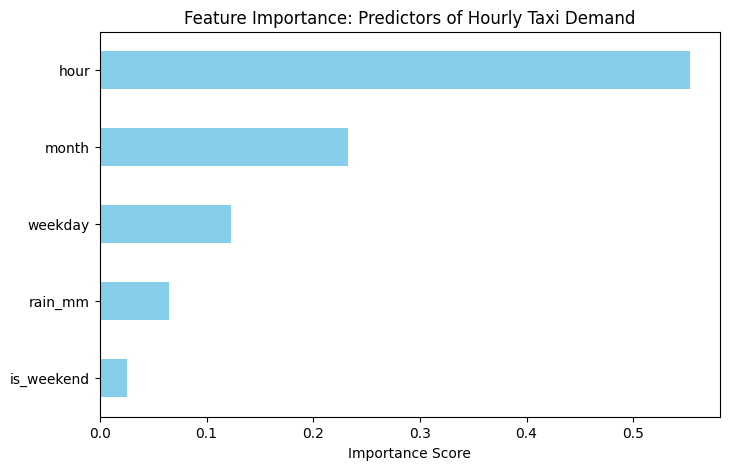

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("/Users/vinaykumar/Documents/Documents/Vinay Data/NYU Masters/Big Data/project/outputs/hourly_weather_demand.csv/part-00000-7e847bea-2190-4cad-8406-599c0313c0b9-c000.csv")
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'], utc=True, errors='coerce')

# --- Feature Engineering ---
df['hour'] = df['pickup_hour'].dt.hour
df['weekday'] = df['pickup_hour'].dt.dayofweek  # Monday=0, Sunday=6
df['month'] = df['pickup_hour'].dt.month
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

# Clean missing values
df = df.dropna(subset=['trip_count'])
df = df.fillna(0)

# --- Define features and target ---
feature_cols = ['hour', 'weekday', 'month', 'is_weekend', 'rain_mm']
X = df[feature_cols]
y = df['trip_count']

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train Model ---
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# --- Evaluate Performance ---
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Model R² score: {r2:.3f}")

# --- Feature Importance ---
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
importances.plot(kind='barh', color='skyblue')
plt.title("Feature Importance: Predictors of Hourly Taxi Demand")
plt.xlabel("Importance Score")
plt.show()


Forecasting R² Score: -19.777
Mean Absolute Error: 8755.04 trips


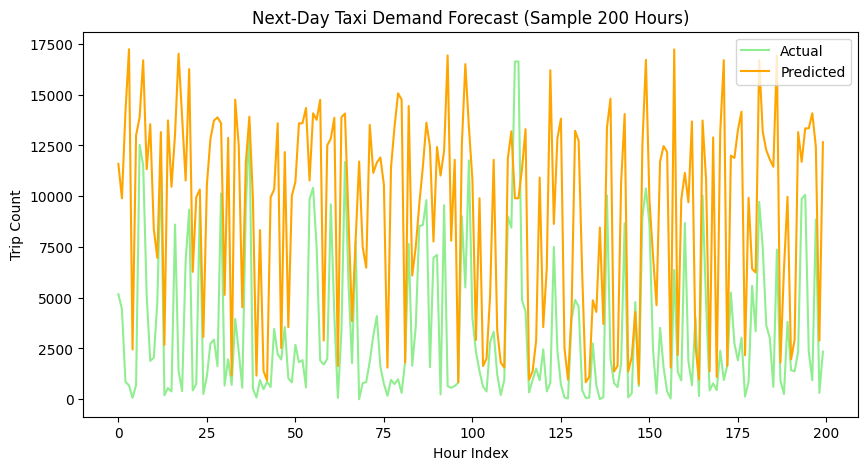

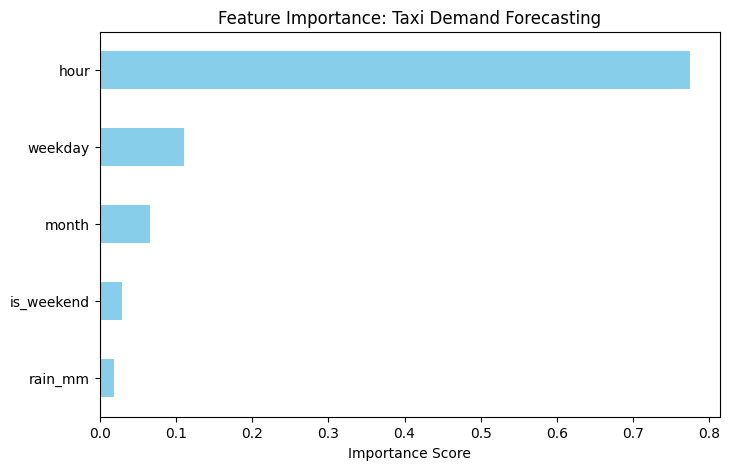

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# --- Load dataset with weather features ---
df = pd.read_csv("/Users/vinaykumar/Documents/Documents/Vinay Data/NYU Masters/Big Data/project/outputs/hourly_weather_demand.csv/part-00000-7e847bea-2190-4cad-8406-599c0313c0b9-c000.csv")

# Parse datetimes
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'], utc=True, errors='coerce')

# --- Feature Engineering ---
df['hour'] = df['pickup_hour'].dt.hour
df['weekday'] = df['pickup_hour'].dt.dayofweek
df['month'] = df['pickup_hour'].dt.month
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

# --- Handle missing data ---
df = df.dropna(subset=['trip_count'])
df = df.fillna(0)

# --- If you have these extra columns from weather data, include them ---
# (If not, the model will still run with rain only)
possible_weather_cols = ['rain_mm', 'temperature_2m (°C)', 'windspeed_10m (km/h)', 'humidity (%)']
existing_weather_cols = [c for c in possible_weather_cols if c in df.columns]

feature_cols = ['hour', 'weekday', 'month', 'is_weekend'] + existing_weather_cols

# --- Define Features and Target ---
X = df[feature_cols]
y = df['trip_count']

# --- Simulate "next-day" forecasting ---
# Sort by time to simulate temporal prediction
df_sorted = df.sort_values('pickup_hour')
split_point = int(len(df_sorted) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# --- Train Model ---
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# --- Evaluate Forecasting Accuracy ---
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Forecasting R² Score: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.2f} trips")

# --- Plot Actual vs Predicted Demand ---
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:200], label='Actual', color='lightgreen')
plt.plot(y_pred[:200], label='Predicted', color='orange')
plt.title("Next-Day Taxi Demand Forecast (Sample 200 Hours)")
plt.xlabel("Hour Index")
plt.ylabel("Trip Count")
plt.legend()
plt.show()

# --- Feature Importance ---
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=True)
plt.figure(figsize=(8,5))
importances.plot(kind='barh', color='skyblue')
plt.title("Feature Importance: Taxi Demand Forecasting")
plt.xlabel("Importance Score")
plt.show()


R² score: 0.464, RMSE: 4080.89


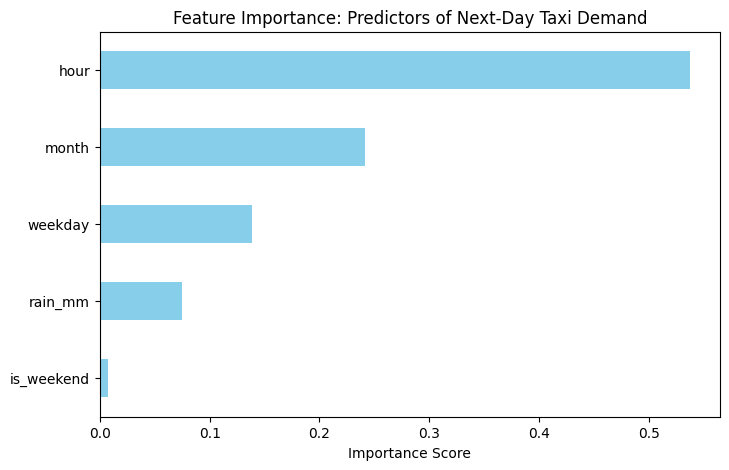

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
df = pd.read_csv("/Users/vinaykumar/Documents/Documents/Vinay Data/NYU Masters/Big Data/project/outputs/hourly_weather_demand.csv/part-00000-7e847bea-2190-4cad-8406-599c0313c0b9-c000.csv")

# Parse datetime
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'], utc=True)

# Sort by time
df = df.sort_values('pickup_hour')

# --- Feature Engineering ---
df['hour'] = df['pickup_hour'].dt.hour
df['weekday'] = df['pickup_hour'].dt.dayofweek
df['month'] = df['pickup_hour'].dt.month
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

# Shift target for next-day prediction (24 hours later)
df['trip_count_next_day'] = df['trip_count'].shift(-24)

# Drop rows where target is NaN (last 24 rows)
df = df.dropna(subset=['trip_count_next_day'])

# Features and target
feature_cols = ['hour', 'weekday', 'month', 'is_weekend', 'rain_mm']
X = df[feature_cols]
y = df['trip_count_next_day']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² score: {r2:.3f}, RMSE: {rmse:.2f}")

# Feature importance
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=True)
plt.figure(figsize=(8,5))
importances.plot(kind='barh', color='skyblue')
plt.title("Feature Importance: Predictors of Next-Day Taxi Demand")
plt.xlabel("Importance Score")
plt.show()


/var/folders/g7/40cnjnqd5975wljg5349nd200000gn/T/ipykernel_4381/1143194059.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



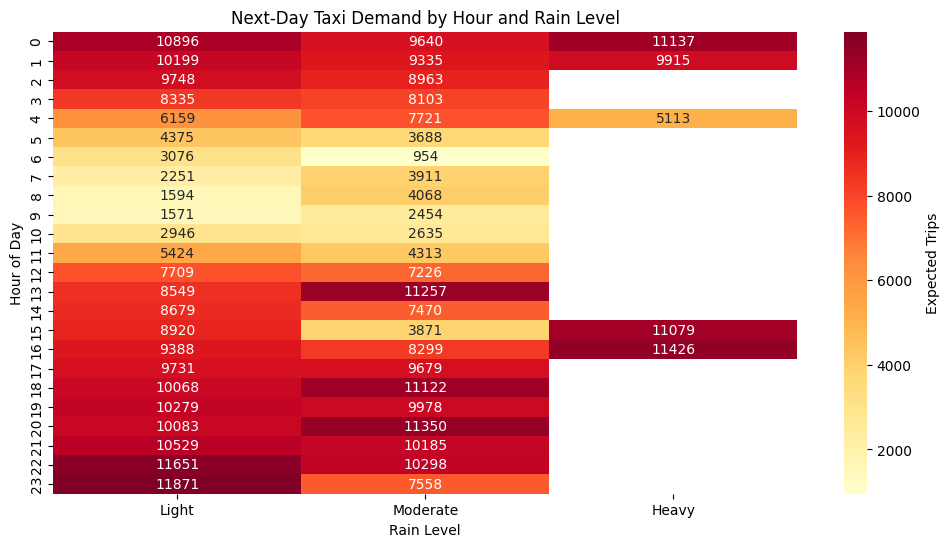

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/Users/vinaykumar/Documents/Documents/Vinay Data/NYU Masters/Big Data/project/outputs/hourly_weather_demand.csv/part-00000-7e847bea-2190-4cad-8406-599c0313c0b9-c000.csv")

# Parse datetime
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'], utc=True)
df['hour'] = df['pickup_hour'].dt.hour
df['weekday'] = df['pickup_hour'].dt.dayofweek
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

# Fill missing rain values with 0
df['rain_mm'] = df['rain_mm'].fillna(0)

# Define rain levels
df['rain_level'] = pd.cut(df['rain_mm'], bins=[-0.1, 2, 10, 100], labels=['Light', 'Moderate', 'Heavy'])

# Compute average demand per hour and rain level
heatmap_data = df.groupby(['hour', 'rain_level'])['trip_count'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='YlOrRd', cbar_kws={'label': 'Expected Trips'})
plt.title("Next-Day Taxi Demand by Hour and Rain Level")
plt.xlabel("Rain Level")
plt.ylabel("Hour of Day")
plt.show()


/var/folders/g7/40cnjnqd5975wljg5349nd200000gn/T/ipykernel_4381/255587811.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



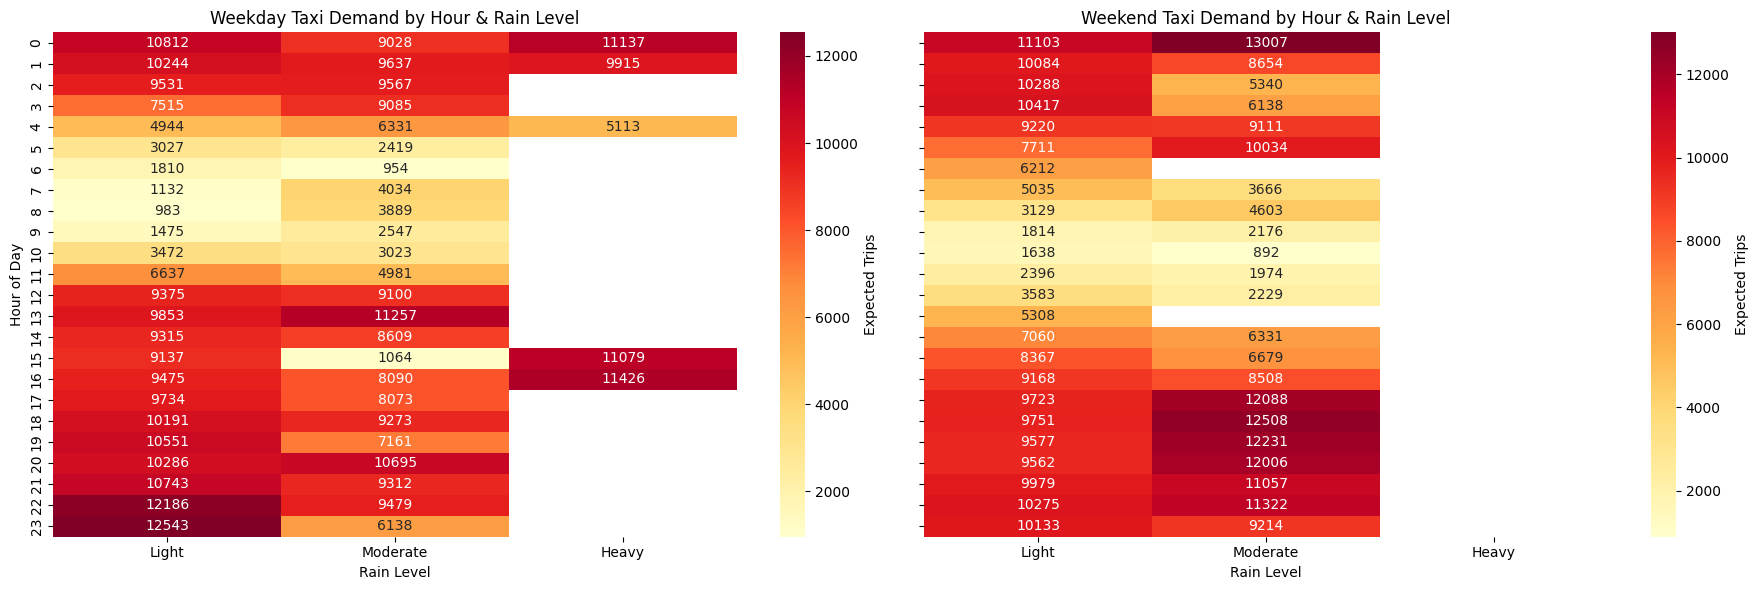

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/Users/vinaykumar/Documents/Documents/Vinay Data/NYU Masters/Big Data/project/outputs/hourly_weather_demand.csv/part-00000-7e847bea-2190-4cad-8406-599c0313c0b9-c000.csv")

# --- Preprocessing ---
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'], utc=True)
df['hour'] = df['pickup_hour'].dt.hour
df['weekday'] = df['pickup_hour'].dt.dayofweek
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
df['rain_mm'] = df['rain_mm'].fillna(0)

# Define rain levels
df['rain_level'] = pd.cut(df['rain_mm'], bins=[-0.1, 2, 10, 100], labels=['Light', 'Moderate', 'Heavy'])

# Compute average demand by hour, rain level, and weekend/weekday
heatmap_data = df.groupby(['hour', 'rain_level', 'is_weekend'])['trip_count'].mean().reset_index()

# Separate weekend and weekday
weekday_data = heatmap_data[heatmap_data['is_weekend'] == 0].pivot(index='hour', columns='rain_level', values='trip_count')
weekend_data = heatmap_data[heatmap_data['is_weekend'] == 1].pivot(index='hour', columns='rain_level', values='trip_count')

# --- Plot Heatmaps ---
fig, axes = plt.subplots(1, 2, figsize=(18,6), sharey=True)

sns.heatmap(weekday_data, annot=True, fmt=".0f", cmap='YlOrRd', ax=axes[0], cbar_kws={'label': 'Expected Trips'})
axes[0].set_title("Weekday Taxi Demand by Hour & Rain Level")
axes[0].set_xlabel("Rain Level")
axes[0].set_ylabel("Hour of Day")

sns.heatmap(weekend_data, annot=True, fmt=".0f", cmap='YlOrRd', ax=axes[1], cbar_kws={'label': 'Expected Trips'})
axes[1].set_title("Weekend Taxi Demand by Hour & Rain Level")
axes[1].set_xlabel("Rain Level")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Load data
df = pd.read_csv("/Users/vinaykumar/Documents/Documents/Vinay Data/NYU Masters/Big Data/project/outputs/hourly_weather_demand.csv/part-00000-7e847bea-2190-4cad-8406-599c0313c0b9-c000.csv")
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'], utc=True)

# Feature engineering
df['hour'] = df['pickup_hour'].dt.hour
df['weekday'] = df['pickup_hour'].dt.dayofweek
df['month'] = df['pickup_hour'].dt.month
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

# Lag feature: previous day's same hour demand
df = df.sort_values('pickup_hour')
df['prev_day_demand'] = df['trip_count'].shift(24)

# Drop rows without lag data
df = df.dropna(subset=['prev_day_demand'])

# Features & target
feature_cols = ['hour', 'weekday', 'month', 'is_weekend', 'rain_mm', 'prev_day_demand']
X = df[feature_cols]
y = df['trip_count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Forecast R²: {r2:.3f}")
print(f"MAE: {mae:.2f} trips")
print(f"RMSE: {rmse:.2f} trips")


Forecast R²: 0.958
MAE: 625.12 trips
RMSE: 1147.17 trips


In [ ]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("/Users/vinaykumar/Documents/Documents/Vinay Data/NYU Masters/Big Data/project/outputs/hourly_weather_demand.csv/part-00000-7e847bea-2190-4cad-8406-599c0313c0b9-c000.csv")
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'], utc=True)

# Feature engineering
df['hour'] = df['pickup_hour'].dt.hour
df['weekday'] = df['pickup_hour'].dt.dayofweek
df['month'] = df['pickup_hour'].dt.month
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

# Lag feature: previous day's same hour demand
df = df.sort_values('pickup_hour')
df['prev_day_demand'] = df['trip_count'].shift(24)
df = df.dropna(subset=['prev_day_demand'])

# Features
feature_cols = ['hour', 'weekday', 'month', 'is_weekend', 'rain_mm', 'prev_day_demand']

# Scenarios for weather
rain_scenarios = {
    'no_rain': 0.0,
    'light_rain': 2.0,
    'heavy_rain': 10.0
}

recommendations = []

for scenario, rain_val in rain_scenarios.items():
    X_scenario = df.copy()
    X_scenario['rain_mm'] = rain_val
    X_scenario_features = X_scenario[feature_cols]
    
    # Predict demand
    y_pred = rf.predict(X_scenario_features)
    
    X_scenario[f'predicted_demand_{scenario}'] = y_pred
    recommendations.append(X_scenario[['pickup_hour', f'predicted_demand_{scenario}']])

# Merge scenarios
rec_table = recommendations[0]
for r in recommendations[1:]:
    rec_table = rec_table.merge(r, on='pickup_hour')

# Fleet allocation suggestion: add 10% buffer for heavy rain
rec_table['fleet_suggestion'] = rec_table['predicted_demand_heavy_rain'] * 1.1
rec_table['fleet_suggestion'] = rec_table['fleet_suggestion'].apply(np.ceil)  # round up

# Show sample
print(rec_table.head())

# Save to CSV
rec_table.to_csv("taxi_fleet_recommendations.csv", index=False)


                pickup_hour  predicted_demand_no_rain  \
0 2009-01-01 16:00:00+00:00                  3581.580   
1 2009-01-01 17:00:00+00:00                  4273.070   
2 2009-01-01 18:00:00+00:00                  5299.420   
3 2009-01-01 19:00:00+00:00                  4542.950   
4 2009-01-01 20:00:00+00:00                  4606.885   

   predicted_demand_light_rain  predicted_demand_heavy_rain  fleet_suggestion  
0                     7951.015                     6790.600            7470.0  
1                     7787.410                     6744.975            7420.0  
2                     7896.185                     6571.220            7229.0  
3                     8156.780                     7025.020            7728.0  
4                     8218.855                     7032.215            7736.0  
